# Asset Management Project: Simulated Portfolios

| Name | EID |
| --- | --- |
| Akshat Johari | aj32864 |
| Aritra Chowdhury  | ac79277 |
| Brandt Green | bwg537 |

### Assumptions:
* Risk free rate = 0
* Trading cost = 0

In [1]:
#import all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import wrds as wrds
import warnings

from scipy import stats
from scipy.stats import skew, kurtosis
import seaborn as sns; sns.set_theme()

warnings.filterwarnings(action = 'ignore')

## Acquiring Data

### Chosen ETFs to represent asset classes

| Asset Class | ETF | CRSP CUSIP |Further Info|
| --- | --- | --- |---|
| U.S. Market | Vanguard Total Stock Market ETF (VTI) | 92290876 | [VTI](https://etfdb.com/etf/VTI/#etf-ticker-profile)|
| International Market | Vanguard FTSE Developed Markets ETF (VEA) | 92194385 | [IGOV](https://etfdb.com/etf/IGOV/#etf-ticker-profile)|
| U.S. Bonds | iShares 3-7 Year Treasury Bond ETF (IEI) | 46428866 | [IEI](https://etfdb.com/etf/IEI/#etf-ticker-profile)|
| International Bonds | iShares International Treasury Bond ETF (IGOV) | 46428811 | [VEA](https://etfdb.com/etf/VEA/#etf-ticker-profile)|
| Other Asset Class (Commodities) | Invesco DB Commodity Index Tracking Fund (DBC) | 46138B10 | [DBC](https://etfdb.com/etf/DBC/#etf-ticker-profile)|

### Input the parameters to the simulation below:

In [2]:
# Date Parameters
start_date = '2010-12-31'
end_date = '2020-12-31'

# Ticker and Weight Parameters
ticker_list = ['VTI', 'VEA', 'IEI', 'IGOV', 'DBC']
target_weights = [0.3, 0.25, 0.2, 0.15, 0.1]

# Rebalancing Frequency Parameter
target_frequency = 'monthly'

df_tickers = pd.DataFrame({'ticker': ticker_list, 'target_weight': target_weights})

### Extract data from WRDS:

In [3]:
# Connect to words. You'll need to input your username and password here.
db = wrds.Connection()

Enter your WRDS username [aritr]:arichowdhury
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


We extract CUSIP Numbers from input Tickers using this table from WRDS: [CRSP - Stock Names](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/monthly-update/stock-events/names/)

In [4]:
tickers_wrds = "'" + "','".join(ticker_list) + "'"

query_string = f"""SELECT nameenddt, cusip, ticker FROM crsp.stocknames WHERE ticker IN ({tickers_wrds})"""
df_cusip_raw = db.raw_sql(query_string)

In [5]:
# Copy data to keep the orginal data source intact
df_cusip = df_cusip_raw.copy()
df_cusip.sort_values(by = 'nameenddt', inplace = True)
df_cusip = df_cusip.groupby('ticker').last().reset_index()[['ticker', 'cusip']]
df_cusip = df_cusip.merge(df_tickers, left_on = 'ticker', right_on = 'ticker')

ticker_list = df_cusip.sort_values(by = 'ticker')['ticker'].tolist()
weight_list = df_cusip.sort_values(by = 'ticker')['target_weight'].tolist()
cusip_list = "'" + "','".join(df_cusip['cusip'].tolist()) + "'"

df_cusip

,ticker,cusip,target_weight
0,DBC,46138B10,0.10
1,IEI,46428866,0.20
2,IGOV,46428811,0.15
3,VEA,92194385,0.25
4,VTI,92290876,0.30


Using the extracted CUSIP Numbers, we are querying data from this table in WRDS: [CRSP - Daily Stock Securities](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/).

In [6]:
query_string = f"""SELECT * FROM crsp.dsf WHERE cusip IN ({cusip_list}) AND date >= '{start_date}' AND date <= '{end_date}' ORDER BY cusip, date"""
df_etf_raw = db.raw_sql(query_string)

WRDS gives us the data in an ugly format, with bad column names and more information than we need. So we will clean it up below:

In [7]:
# Copy data to keep the orginal data source intact
df_etf = df_etf_raw.copy() 

# This table in WRDS does not have ticker info so we merge the data with our previous cusip df to tack on the tickers
df_etf = df_etf.merge(df_cusip, left_on = 'cusip', right_on = 'cusip') 

# We only care about these three columns
df_etf = df_etf[['date','ticker','ret']] 
df_etf['date'] = pd.to_datetime(df_etf['date']) 

df_etf = df_etf.set_index('date')

# Rename columns appropriately
df_etf = df_etf.rename(columns={'ret':'return'}) 

## Portfolio Statistics
Now now that we have the data in a pretty format, we can calculate some summary statistics for each asset class. 

First, we add a few helper functions which we will apply to our returns dataframe to calculate those summary stats. For all the functions, they receive a series as input and will return one number as the output.

In [8]:
def daily_var_1(series:pd.Series):
    """
    Calculate the the daily value at risk of the returns with a 1% threshold.
    """
    return np.percentile(series, .01)


def conditional_var_1(series:pd.Series):
    """
    Calculate the average loss of returns, given that the 1% threshold has been breached.
    """
    bottom_centile = series[series <= np.percentile(series, .01)]
    return bottom_centile.mean()


def max_draw_down(series:pd.Series):
    """
    What is the largest peak to trough percentage decline of the returns.
    """
    cumulative_returns = np.cumproduct((series + 1))
    highest_value = 1
    biggest_draw_down = 0
    for port_value in cumulative_returns:
        peak_to_trough_return = port_value/highest_value - 1
        if peak_to_trough_return < biggest_draw_down:
            biggest_draw_down = peak_to_trough_return
        if port_value > highest_value:
            highest_value = port_value

    return biggest_draw_down


def draw_down_days(series:pd.Series):
    """
    What is the largest peak to trough percentage decline of the returns.
    """
    cumulative_returns = np.cumproduct((series + 1))
    highest_value = 1
    biggest_draw_down = 0
    peak_date = series.index[0]
    draw_down_start_date = None # Initially the draw down start date will be the first date
    draw_down_end_date = None

    for date, port_value in zip(series.index, cumulative_returns):
        peak_to_trough_return = port_value/highest_value - 1
        if peak_to_trough_return < biggest_draw_down:
            biggest_draw_down = peak_to_trough_return
            draw_down_start_date = peak_date
            draw_down_end_date = date

        if port_value > highest_value: # Set the new highest portfolio value and draw_down_start_date
            highest_value = port_value
            peak_date = date

    days_of_drawdown = (draw_down_end_date - draw_down_start_date)
    return days_of_drawdown


def downside_std(series:pd.Series):
    """
    Standard deviation of negative returns only.
    """
    mn = series.mean()
    return np.sqrt(((series[series < 0] - mn)**2).sum() / len(series))


def proportion_positive_returns(series:pd.Series):
    """
    What percent of the daily portfolio returns are postive?
    """
    return len(series[series>0])/len(series)


def annualized_return(series:pd.Series):
    """
    Calculate annualized returns
    """
    return ((np.cumproduct(series + 1)**0.1)[-1] - 1)


def calculate_portfolio_statistics(df_returns:pd.DataFrame) ->pd.DataFrame:
    """
    This function is here to just aggregate all the relevant info and make it presentable.
    """

    # Groupby ticker and get the statistics below.
    summary_stats = df_returns.groupby(['ticker']).aggregate(['mean', 'std', 'skew',
     kurtosis, daily_var_1, conditional_var_1, max_draw_down, draw_down_days, downside_std, 
                                                              proportion_positive_returns, annualized_return])

    # Reset Column Indexes post groupby
    summary_stats.columns = summary_stats.columns.get_level_values(1)

    # Create a few new performance metrics based on the statistics above:
    summary_stats['Annualized_Return'] = summary_stats['annualized_return']
    summary_stats['Annualized_Std'] = summary_stats['std'] * 252**(0.5)
    summary_stats['Sharpe_Ratio'] = summary_stats['Annualized_Return']/summary_stats['Annualized_Std']
    summary_stats['Sortino_Ratio'] = summary_stats['Annualized_Return']/(summary_stats['downside_std'] * 252 ** (0.5))

    # Make the df pretty:
    summary_stats = summary_stats.drop(columns=['mean','std','downside_std','annualized_return'])
    summary_stats.columns = [column.title() for column in summary_stats.columns]# Rearrange columns
    
    # Rearrange columns
    summary_stats = summary_stats[['Annualized_Return','Annualized_Std','Sharpe_Ratio','Sortino_Ratio','Skew','Kurtosis',
    'Daily_Var_1','Conditional_Var_1','Max_Draw_Down','Draw_Down_Days','Proportion_Positive_Returns']] 
    
    # Rename columns
    summary_stats.rename(columns = {'Annualized_Return':'Annualized Return',
                                    'Annualized_Std': 'Annualized Standard Deviation',
                                    'Sharpe_Ratio': 'Sharpe Ratio',
                                    'Sortino_Ratio': 'Sortino Ratio',
                                    'Daily_Var_1': 'Daily Value at Risk (1% Threshold)',
                                    'Conditional_Var_1': 'Conditional Value at Risk (1% Threshold)',
                                    'Max_Draw_Down': 'Maximum Drawdown',
                                    'Draw_Down_Days': 'Maximum Drawdown Days',
                                    'Proportion_Positive_Returns': 'Proportion of Positive Returns'}, inplace = True)
    
    return summary_stats.T

## Simulation Engine
We now develop a simulation engine which will have the capacity to test out various strategies based on the chosen securities and their historical returns.
The idea is that you can specify your rebalancing frequency, and any arbitrary trading strategy where the strategy is specified by a new function you create. This new function should receive as input a dateframe of security returns and return a pandas series where the index is the security tickers and the values are their weights. 

This strategy function is applied once every rebalancing date.

See the example function "target_portfolio_strategy" a few cell below.

First, to make it easier on ourselves, we create a new dataframe where the tickers are the columns and each row represents the return for a specific day. This just saves us from having to do a bunch of annoying groupbys later on. This dataframe is also the input for the arbitrary strategy function you create.

In [9]:
# Pivot DataFrame to get Tickers as Columns
df_returns = df_etf[['ticker','return']].pivot(columns = 'ticker').reset_index()

# Pivot makes our column names multi-indexed. We want the sub-index
df_returns.columns = df_returns.columns.get_level_values(1) 
df_returns = df_returns.rename(columns = {'':'date'}).set_index('date') 

### Helper Functions

The functions below carry out the following functions:
* Calculate the correct Rebalancing Dates for your strategy
* Calculate Target Portfolio based on input strategy function
* Build Similated Portfolio based on target strategy

In [10]:
def get_rebalance_dates(df:pd.DataFrame, frequency='monthly'):
    """
    Calculate rebalance dates based on the input frequency
    """
    if frequency == 'monthly':
        return get_end_of_month_dates(df)
    elif frequency == 'daily':
        return df.index.unique()
    elif frequency == 'yearly':
        return get_end_of_year_dates(df)

    
def get_end_of_month_dates(df:pd.DataFrame) -> pd.Series:
    """
    Calculate last date in each month of the input series.
    """
    # Keep the original DataFrame intact
    df2 = df.copy().reset_index() 
    
    # Create year and month columns which we use to group by in a second
    df2['year'] = df2['date'].dt.year
    df2['month'] = df2['date'].dt.month

    # Group by the year, then the month and then grab the last date associated with each of those combinations in our data set
    return df2.groupby(['year', 'month']).last()['date'].to_list()


def get_end_of_year_dates(df:pd.DataFrame) -> pd.Series:
    """
    Calculate last date in each year of the input series.
    """
    # Keep the original DataFrame intact
    df2 = df.copy().reset_index() 
    df2['year'] = df2['date'].dt.year
    return df2.groupby('year').last()['date'].to_list()


def target_portfolio_strategy(df_returns:pd.DataFrame):
    """
    Calculate target weights based on the input strategy.
    For the purpose of the project, the target weights are set to the mentioned values.
    """
    strategy_weights = df_cusip[['ticker','target_weight']].set_index('ticker').sort_index()
    strategy_weights.columns = ['weight']
    return strategy_weights


def simulate_portfolio_strategy(df_returns:pd.DataFrame, initial_weights, strategy_function, rebalance_frequency='monthly'):
    """
    Build Simulated Portfolio based on input parameters
    """
    
    rebalance_dates =  get_rebalance_dates(df_returns, frequency=rebalance_frequency)
    
    # Get all the days in our simulated time period
    date_list = list(df_returns.index.unique()) 
    
    # The date before our start date, which will be first entry into portfolio dataframe
    day_before_start = date_list[0] - pd.DateOffset(1) 
    
    # Create dataframe to store portfolio values at each date
    df_portfolio = pd.DataFrame(columns=ticker_list) 
    
    # Starting wealth
    initial_wealth = 100 

    # Set the intial portfolio values
    df_portfolio.loc[day_before_start] = (initial_weights * initial_wealth).T.values.flatten()

    # This flag will be used when updated portfolio values below
    previous_date = day_before_start 

    # Loop through all of the dates and calculate the value of the potfolio at each day. Rebalance when necessary.
    for date in date_list:
        
        # Grab the security returns on that date
        returns = df_returns.loc[date] 
        
        # New, ending port values are the previous port values mutliplied by their respective returns
        df_portfolio.loc[date] = df_portfolio.loc[previous_date] * (1 + returns) 

        # If you are on a rebalance date, then rebalance at the end of today back to your target or strategy weights
        # This will overwrite the wealths above, but it will still incoporate the returns earned for the day
        if date in rebalance_dates:
            # Apply the strategy function to get the appropriate weights. The strategy function will only receive the information from all previous days.
            strategy_weights = strategy_function(df_returns[df_returns.index <= date]) 
            rebalanced_wealths = (df_portfolio.loc[date].sum() * strategy_weights).T.values.flatten()
            df_portfolio.loc[date] = rebalanced_wealths
        
        # Update this for the next loop
        previous_date = date 

    df_portfolio['wealth'] = df_portfolio.sum(axis=1)
    df_portfolio['returns'] = df_portfolio['wealth'].pct_change()
    df_portfolio['cum_returns'] = np.cumproduct(1 + df_portfolio['returns'])

    return df_portfolio

### Target Portfolio Performance
Below we simulate the results where our strategy is to simply rebalance back to our target weights every month, day or year, depending on the input frequency. The resulting dataframe contains columns where the values are the dollar amount of the security.

In [11]:
initial_weights = target_portfolio_strategy(df_returns)
target_portfolio_df = simulate_portfolio_strategy(df_returns, initial_weights=initial_weights, strategy_function=target_portfolio_strategy, rebalance_frequency=target_frequency)

## Finding the portfolio with the highest Sharpe Ratio
The approach we use to find the highest sharpe ratio portfolio is a Monte Carlo simulation. We randomly sample a large amount of weights, calculate the expected return and variance for each portfolio and finally select the portfolio with the highest Sharpe Ratio.  

In [12]:
def calculate_annualized_port_std(weights, cov_matrix) -> float:
    """
    Calculate the annualized portfolio standard deviation
    """
    var = weights.dot(cov_matrix).dot(weights)
    std = np.sqrt(252*var)
    return std

In [13]:
# Covariance Matrix for daily returns
cov_matrix = df_returns.cov()

# Individual Asset Returns
annualized_returns = df_returns.mean() * 252

simulation_count = 1_000_000

# Matix where each row contains simulated port weights
simulated_weights = np.random.uniform(size=(simulation_count,len(ticker_list))) 

# Normalize them so they add up to 1
port_weights_matrix = simulated_weights/simulated_weights.sum(axis=1)[:,np.newaxis] 

# Filter out any portfolios with a weight greater than 45 %
condition_mask = ~np.any(port_weights_matrix > .45, axis=1) 
port_weights_matrix = port_weights_matrix[condition_mask]

# Dataframe to store port info
simulated_ports_df = pd.DataFrame(data=port_weights_matrix,columns=[f'Weight ({ticker})' for ticker in ticker_list]) 
simulated_ports_df['Returns'] = port_weights_matrix @ annualized_returns 
simulated_ports_df['Risk'] = [calculate_annualized_port_std(port_weights,cov_matrix=cov_matrix) for port_weights in port_weights_matrix]
simulated_ports_df['Sharpe_Ratio'] = simulated_ports_df['Returns']/simulated_ports_df['Risk']

# Sort by highest sharpe ratio
simulated_ports_df = simulated_ports_df.sort_values('Sharpe_Ratio', ascending=False) 
optimal_portfolio = simulated_ports_df.head(1)

The portfolio weights with the highest Sharpe Ratio is displayed below:

In [14]:
optimal_portfolio.iloc[:, [0,1,2,3,4]].T

,464584
Weight (DBC),0.000013
Weight (IEI),0.447425
Weight (IGOV),0.296650
Weight (VEA),0.002894
Weight (VTI),0.253017


### Efficient Frontier Plot

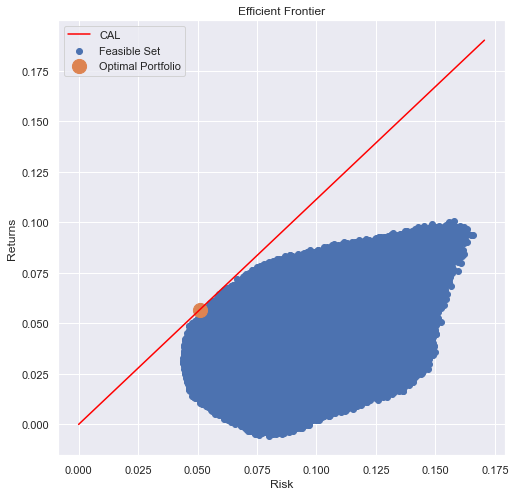

In [15]:
plt.figure(figsize = (8,8))
plt.scatter(simulated_ports_df['Risk'], simulated_ports_df['Returns'], label = 'Feasible Set') 
plt.scatter(optimal_portfolio['Risk'], optimal_portfolio['Returns'], s = 200, label = 'Optimal Portfolio')

cal_line_slope = optimal_portfolio['Sharpe_Ratio'].iloc[0]
cal_line_x_vals = np.arange(0, np.max(simulated_ports_df['Risk']) + .005, .0001) # Generate risk inputs so that we can plot CAL

plt.plot(cal_line_x_vals, cal_line_x_vals*cal_line_slope, label='CAL', color='red')

plt.legend()
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Returns')
plt.show()

## Optimal Portfolio Performance
Now we can run this optimal portfolio through our simulation engine to see how it actually performs.

In [16]:
def optimal_port_strategy(df_returns:pd.DataFrame):
    """
    Set the strategy for the optimal portfolio, i.e., the weights calculated through the Monte Carlo simulation.
    """
    optimal_weights = optimal_portfolio.iloc[0,:len(ticker_list)]
    optimal_weights.index = ticker_list
    return optimal_weights


optimal_weights = optimal_port_strategy(df_returns)
optimal_portfolio_df = simulate_portfolio_strategy(df_returns, initial_weights=optimal_weights, strategy_function=optimal_port_strategy, rebalance_frequency=target_frequency)

## Performance Comparison of Target Portfolio vs Optimal Portfolio vs Individual ETFs

### Portfolio Statistics

In [17]:
# Arrange ETF and Portfolio DataFrames in same order and append for Portfolio Statistics
df_tgt = target_portfolio_df[['returns']].rename(columns = {'returns':'return'})[1:]
df_tgt.insert(0, 'ticker', 'Target Portfolio')

df_opt = optimal_portfolio_df[['returns']].rename(columns = {'returns':'return'})[1:]
df_opt.insert(0, 'ticker', 'Optimal Portfolio')

df_all = df_etf.append(df_tgt).append(df_opt)

In [18]:
# List of Column Names to rearrange DataFrame
column_list = ticker_list.copy()
column_list.extend(['Target Portfolio', 'Optimal Portfolio'])

# Rearrange Portfolio statistics Result
df_port_stats = calculate_portfolio_statistics(df_all)[column_list]
df_port_stats

ticker,DBC,IEI,IGOV,VEA,VTI,Target Portfolio,Optimal Portfolio
Annualized Return,-0.056404,0.029328,0.019766,0.059081,0.137654,0.061403,0.055471
Annualized Standard Deviation,0.159661,0.030485,0.078033,0.187952,0.175693,0.104547,0.049828
Sharpe Ratio,-0.353275,0.962048,0.2533,0.314342,0.78349,0.587326,1.113245
Sortino Ratio,-0.478523,1.374306,0.351455,0.41663,1.053201,0.778169,1.51873
Skew,-0.546755,0.126827,-0.175788,-1.020486,-0.674023,-1.052182,-0.595636
Kurtosis,3.839162,2.508051,1.8744,12.383283,15.432661,12.254021,8.759378
Daily Value at Risk (1% Threshold),-0.075113,-0.010253,-0.022912,-0.1109,-0.109638,-0.062357,-0.027815
Conditional Value at Risk (1% Threshold),-0.077844,-0.010951,-0.02298,-0.111803,-0.113809,-0.062503,-0.029328
Maximum Drawdown,-0.661409,-0.044884,-0.157839,-0.357344,-0.350003,-0.222669,-0.091484
Maximum Drawdown Days,3307 days 00:00:00,680 days 00:00:00,497 days 00:00:00,787 days 00:00:00,33 days 00:00:00,66 days 00:00:00,19 days 00:00:00


As can be seen from the table, the Optimal Portfolio has the highest Sharpe Ratio. It has similar annualized returns to the Target Portfolio; however, it has a much lower annualized standard deviation compared to the Target Portfolio.

### Cumulative Returns Plot over 10 Years

In [19]:
# Creating a cumulative wealth return for all the assets where the starting wealth is $100

df_returns_cumulative = (df_returns+ 1).cumprod() * 100
day_before_start = df_returns_cumulative.index[0] - pd.DateOffset(1) 
initial_wealth_row = pd.DataFrame(data=np.array([[100]*len(ticker_list)]), columns=df_returns_cumulative.columns, index=[day_before_start])
df_returns_cumulative = pd.concat([initial_wealth_row,df_returns_cumulative])

We now plot the Cumulative Returns of all ETFs and the two Portfolios to compare their Performance over 10 years

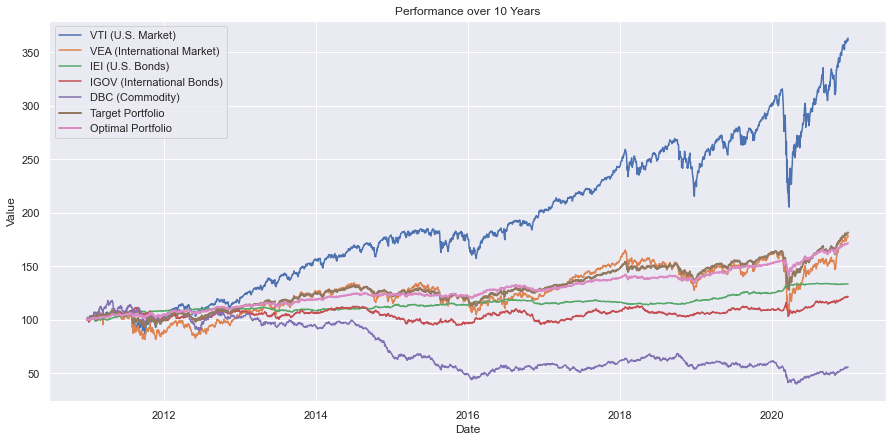

In [20]:
# Plot Cumulative Returns for each ETF, Target Portfolio, and Optimal Portfolio
plt.figure(figsize = (15,7))

plt.plot(df_returns_cumulative['VTI'], label = 'VTI (U.S. Market)')
plt.plot(df_returns_cumulative['VEA'], label = 'VEA (International Market)')
plt.plot(df_returns_cumulative['IEI'], label = 'IEI (U.S. Bonds)')
plt.plot(df_returns_cumulative['IGOV'], label = 'IGOV (International Bonds)')
plt.plot(df_returns_cumulative['DBC'], label = 'DBC (Commodity)')

plt.plot(target_portfolio_df['wealth'], linewidth = 2, label = 'Target Portfolio')
plt.plot(optimal_portfolio_df['wealth'], linewidth = 2, label = 'Optimal Portfolio')
plt.title('Performance over 10 Years')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend()
plt.show()

The Optimal Portfolio, as previously discussed, has similar returns compared to the Target Portfolio, but with much lower risk. 